Exponential growth with variable rates
======================================
Here we want to train a parameter dependency of the PDE. To this end we consider:

\begin{align*}
    \dot{u} &= k u  \text{  in } [0, 1] \\
    u(0) &= 1
\end{align*}

Where we want to learn the solution for $k \in [0, 2]$.
The exact solution is $u(x) = e^{kx}$.

In [1]:
import torchphysics as tp
import pytorch_lightning as pl
import torch
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2" # select GPUs to use

Define spaces and domains, we need one for $k$ too.

In [2]:
X = tp.spaces.R1('x')
K = tp.spaces.R1('k')
U = tp.spaces.R1('u')
I_x = tp.domains.Interval(X, 0, 1)
I_k = tp.domains.Interval(K, 0, 2)

The model gets the inputs $x$ and $k$:

In [3]:
model = tp.models.Sequential(
    tp.models.FCN(input_space=X*K, output_space=U)
)

Next, create the needed conditions:

In [4]:
inner_sampler = tp.samplers.RandomUniformSampler(I_x*I_k, n_points=10000)

def pde_residual(u, x, k):
    return tp.utils.grad(u, x) - k * u

pde_condition = tp.conditions.PINNCondition(module=model,
                                            sampler=inner_sampler,
                                            residual_fn=pde_residual,
                                            name='pde_condition')

In [5]:
boundary_sampler = tp.samplers.RandomUniformSampler(I_x.boundary_left*I_k, n_points=2000)

def boundary_residual(u):
    return u - 1.0

boundary_condition = tp.conditions.PINNCondition(module=model,
                                                 sampler=boundary_sampler,
                                                 residual_fn=boundary_residual,
                                                 name='boundary_condition')

Start the trainings process:

In [6]:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=0.001)

solver = tp.solver.Solver([pde_condition, boundary_condition], optimizer_setting=optim)

trainer = pl.Trainer(gpus=1,
                     max_steps=8000,
                     logger=False,
                     benchmark=True,
                     checkpoint_callback=False)
                     
trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 921   
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
921       Trainable params
0         Non-trainable params
921       Total params
0.004     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

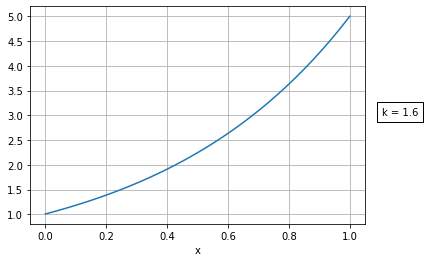

In [ ]:
plot_sampler = tp.samplers.PlotSampler(plot_domain=I_x, n_points=100, device='cuda', 
                                       data_for_other_variables={'k': 1.6})
fig = tp.utils.plot(model, lambda u: u, plot_sampler)

Here we create a error plot over different $k$ values:

Text(0, 0.5, 'max error')

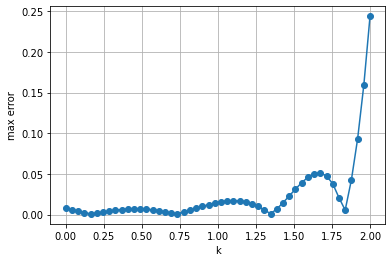

In [ ]:
import matplotlib.pyplot as plt
k_tensor = torch.linspace(0, 2.0, 50)
error_tensor = torch.zeros_like(k_tensor)
for i in range(len(k_tensor)):
    plot_sampler = tp.samplers.PlotSampler(plot_domain=I_x, n_points=100, device='cuda', 
                                           data_for_other_variables={'k': k_tensor[i]})
    inp_data = plot_sampler.sample_points()
    out = model(inp_data).as_tensor
    error_tensor[i] = torch.max(torch.abs(out - torch.exp(k_tensor[i]*inp_data[:, 'x'].as_tensor)))
plt.plot(k_tensor, error_tensor.detach(), marker='o')
plt.grid()
plt.xlabel('k')
plt.ylabel('max error')